# Data Scraping ⛏️ - Iteration 1
The goal of this project is to distinguish between false and truthful information. To achieve this, it's essential to gather a solid dataset of recent true and fake news for training the model.

First, let's start by importing the necessary libraries and checking their versions.

In [88]:
import time
import pandas
import sklearn
import seaborn
import requests
import cloudscraper
from datetime import datetime
from bs4 import BeautifulSoup

print("Library versions:")
print("- pandas version:", pandas.__version__)          # 2.2.3
print("- sklearn version:", sklearn.__version__)         # 1.6.1
print("- seaborn version:", seaborn.__version__)        # 0.13.2
print("- requests version:", requests.__version__)      # 2.31.0

Library versions:
- pandas version: 2.2.3
- sklearn version: 1.6.1
- seaborn version: 0.13.2
- requests version: 2.31.0


## Article Details 🔎
The data I want to derive from each article is the following:
- Title 
- URL
- Source 
- Journalist(s) (if available)
- Published Date
- Content of the article
- Category (Politics, Sports, etc.) - The data had to be categorised manually, as most of it had already been scraped.
- Label: either "Fake" (0) or "Real" (1).

## Fake News ❌
As the internet evolves, most fake news websites are taken down or become unavailable. Therefore, the only ones I was able to find are:
- https://theonion.com/ (done)
- https://thepeoplesvoice.tv/ (done)
- https://www.theinteldrop.org/ (done)
- https://spacexmania.com/ (done)
- beforeitsnews.com
- naturalnews.com
- newspunch.com
- realrawnews.com
- worldnewsdailyreport.com
- thegatewaypundit.com
- babylonbee.com
- dailysquib.co.uk

### <a href="https://theonion.com/">The Onion</a> 🧅
The Onion is an American digital media company and newspaper organization that publishes satirical articles on international, national and local news.

In [ ]:
onion_url = 'https://theonion.com'

def scrape_onion_article_details(link):
    response = requests.get(link)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    # article text
    article_text = ''
    article_body = soup.find('div', class_='entry-content single-post-content single-post-content--has-watermark wp-block-post-content has-echo-font-size is-layout-flow wp-block-post-content-is-layout-flow')
    if article_body:
        paragraphs = article_body.find_all('p')
        for p in paragraphs:
            article_text += p.get_text(strip=True) + '\n\n'

    # date
    publication_date = ''
    time_tag = soup.find('time')
    if time_tag and 'datetime' in time_tag.attrs:
        publication_date = time_tag['datetime']

    return article_text, publication_date

def scrape_onion_news(pages=10):
    articles = []
    page = 1

    while page <= pages:
        url = f'{onion_url}/news/page/{page}/'
        response = requests.get(url)

        if response.status_code != 200:
            break

        soup = BeautifulSoup(response.text, 'html.parser')

        # article containers
        article_count = 0
        for article in soup.find_all('h3', class_='has-link-color wp-elements-aad9b6425bfbbfe81f8771ca6f420d00 wp-block-post-title has-text-color has-primary-2-color has-rocky-condensed-font-family'):
            title = article.get_text(strip=True)
            link_tag = article.find('a')
            href = link_tag['href'] if link_tag else ''

            # link is a full URL
            link = href if href.startswith('http') else f"{onion_url}{href}"

            # scrape article details
            article_text, publication_date = scrape_onion_article_details(link)

            articles.append({
                'Title': title,
                'URL': link,
                'Source': 'The Onion',
                'Journalist(s)': '',  # authors are not listed
                'Published Date': publication_date,
                'Content': article_text,
                'Label': 0  # fake news
            })
            article_count += 1

        # break if no articles are found on the current page
        if article_count == 0:
            break

        page += 1

    return articles

# 10 pages
onion_articles = scrape_onion_news(pages=10)

# save to csv
df = pandas.DataFrame(onion_articles)
df.to_csv("the_onion_fake.csv", index=False)

print("Done.")

Done.


### <a href="https://thepeoplesvoice.tv">The People's Voice</a> 🔊 
Founded by Sean Adl-Tabatabai and Sinclair Treadway in 2014. It has published fake stories, such as "claims that the Queen had threatened to abdicate if the UK voted against Brexit."

In [ ]:
base_url = 'https://thepeoplesvoice.tv'

def scrape_article_details(link):
    response = requests.get(link)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    # article text
    article_text = ''
    article_body = soup.find('div', class_='entry-content clearfix')
    if article_body:
        paragraphs = article_body.find_all('p')
        for p in paragraphs:
            article_text += p.get_text(strip=True) + '\n\n'

    # date
    publication_date = ''
    date_span = soup.find('span', class_='entry-meta-date updated')
    if date_span:
        date_link = date_span.find('a')
        if date_link:
            publication_date = date_link.get_text(strip=True)

    # author
    author = ''
    author_span = soup.find('span', class_='entry-meta-author author vcard')
    if author_span:
        author_link = author_span.find('a', class_='fn')
        if author_link:
            author = author_link.get_text(strip=True)

    return article_text, publication_date, author

def scrape_news(pages=10):
    articles = []
    for page in range(1, pages + 1):
        url = f'{base_url}/category/news/page/{page}/'
        response = requests.get(url)

        if response.status_code != 200:
            break

        soup = BeautifulSoup(response.text, 'html.parser')

        # article containers
        article_count = 0
        for article in soup.find_all('h3', class_='entry-title mh-posts-list-title'):
            title = article.get_text(strip=True)
            link_tag = article.find('a')
            href = link_tag['href'] if link_tag else ''

            # link is a full URL
            link = href if href.startswith('http') else f"{base_url}{href}"

            # article details
            article_text, publication_date, author = scrape_article_details(link)

            articles.append({
                'Title': title,
                'URL': link,
                'Source': "The People's Voice",
                'Journalist(s)': author,
                'Published Date': publication_date,
                'Content': article_text,
                'Label': 0  # fake news
            })
            article_count += 1

        # break if no articles are found on the current page
        if article_count == 0:
            break

    return articles

# 10 pages
news_articles = scrape_news(pages=10)

# save to csv
df = pandas.DataFrame(news_articles)
df.to_csv("peoples_voice_fake.csv", index=False)

print("Done.")

Done.


### <a href="https://www.theinteldrop.org">The Intel Drop</a>💧
The Intel Drop is a common Russian disinformation website.	

Headers and cloudscraper are used here to simulate a real browser and bypass anti-bot measures put in order to prevent the scraping. Headers improve the legitimacy of requests by incorporating details such as User-Agent and language preferences. On the other hand, cloudscraper assists in bypassing Cloudflare protections, including CAPTCHAs, while maintaining session consistency to ensure smooth data extraction.

In [42]:
base_url = 'https://www.theinteldrop.org'

scraper = cloudscraper.create_scraper()

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Referer': base_url
}

def scrape_article_details(link):
    try:
        response = scraper.get(link, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        # skip p tags with this specific class
        def is_valid_paragraph(p):
            cls = p.get('class', [])
            return ('has-text-align-center' not in cls and
                    'has-text-color' not in cls and
                    'has-medium-font-size' not in cls)

        all_paragraphs = soup.select('div.entry-content p')
        filtered_paragraphs = [p for p in all_paragraphs if is_valid_paragraph(p)]

        # combine cleaned content
        article_text = ' '.join(p.get_text(strip=True) for p in filtered_paragraphs).replace('\u00a0', ' ').strip()

        # date
        date = soup.find('time', class_='entry-date published')
        publication_date = date.get_text(strip=True) if date else ''

        # author
        author = ''
        first_paragraph = next((p for p in filtered_paragraphs if p.find('strong') and p.find('em')), None)
        if first_paragraph:
            em_tag = first_paragraph.find('em')
            if em_tag and "by" in em_tag.text.lower():
                strong_tag = first_paragraph.find('strong')
                if strong_tag:
                    author = strong_tag.find('em').get_text(strip=True)

        return article_text, publication_date, author
    except Exception as e:
        return '', '', ''

def scrape_news(pages=2):
    articles = []
    for page in range(1, pages + 1):
        url = f'{base_url}/category/featured/page/{page}/'

        response = scraper.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        articles_found = soup.find_all('h2', class_='penci-entry-title')

        for article in articles_found:
            title = article.get_text(strip=True)
            link = article.find('a')['href']
            if not link.startswith('http'):
                link = f"{base_url}{link}"
                
            article_text, date, author = scrape_article_details(link)
            articles.append({
                'Title': title,
                'URL': link,
                'Source': "The Intel Drop",
                'Journalist(s)': author,
                'Published Date': date,
                'Content': article_text,
                'Label': 0 # fake news
            })
            time.sleep(1)  # delay between article requests

    return articles

# 2 pages
news_articles = scrape_news(pages=2)

# save to csv
df = pandas.DataFrame(news_articles)
df.to_csv("intel_drop_fake.csv", index=False)

print("Done.")


Done.


### <a href="https://spacexmania.com">SpaceXMania</a> 🪐
Accused by Christopher Blair, the owner of The Last Line of Defense, of plagiarizing its stories via a generative AI model. The New York Times also found that many stories from SpaceXMania were produced by generative AI. The Australian Associated Press found that the site team used ChatGPT for writing content. Accused by academics of deceptively labeling clickbait content as satire.

In [41]:
base_url = 'https://spacexmania.com'

category_url = f'{base_url}/category/satire/'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Referer': base_url
}

def scrape_article_details(link):
    try:
        res = requests.get(link, headers=headers)
        soup = BeautifulSoup(res.text, 'html.parser')

        # date
        date_tag = soup.find('time', class_='entry-date published')
        publication_date = date_tag.get_text(strip=True) if date_tag else ''

        # author
        author_tag = soup.find('span', class_='author-name')
        author = author_tag.get_text(strip=True) if author_tag else ''

        # flatten all p tag content into a single string
        paragraphs = soup.find_all('p')
        article_text = ' '.join(
            p.get_text(strip=True).replace('\n', ' ').replace('\r', ' ')
            for p in paragraphs if p.get_text(strip=True)
        ).replace('\u00a0', ' ').strip()

        return article_text, publication_date, author
    
    except Exception as e:
        return '', '', ''

def scrape_spacexmania(max_articles=150):
    articles = []
    page = 1

    while len(articles) < max_articles:
        url = f'{category_url}page/{page}/'
        try:
            res = requests.get(url, headers=headers)
            soup = BeautifulSoup(res.text, 'html.parser')
            post_blocks = soup.find_all('h2', class_='entry-title')

            for post in post_blocks:
                if len(articles) >= max_articles:
                    break

                a_tag = post.find('a')
                title = a_tag.get_text(strip=True)
                link = a_tag['href']
                if not link.startswith('http'):
                    link = f"{base_url}{link}"

                article_text, date, author = scrape_article_details(link)

                articles.append({
                    'Title': title,
                    'URL': link,
                    'Ssource': "SpaceXMania",
                    'Journalist(s)': author,
                    'Published Date': date,
                    'Content': article_text,
                    'Label': 0 # fake news
                })
                time.sleep(1)  # polite scraping delay

        except Exception as e:
            break

        page += 1

    return articles

# save 150 articles
space_articles = scrape_spacexmania(max_articles=150)

# save to csv
df = pandas.DataFrame(space_articles)
df.to_csv("spacexmania_fake.csv", index=False)

print("Done.")

Done.


## Real News ✅ 
Opposite goes for the real news, it is much easier to find truthful websites:
- https://www.bbc.com (done)
- https://www.reuters.com/ (denied access)
- https://apnews.com/ (done)
- https://www.nytimes.com/
- washingtonpost.com
- bloomberg.com
- techcrunch.com
- theverge.com
- sciencenews.org
- nationalgeographic.com
- aljazeera.com
- theguardian.com

### <a href="https://www.bbc.com">BBC</a> 🌐

I believe that starting with the BBC would be the most straightforward option, as my research shows they are ranked as the most trusted news source by Americans. Even though we live in Europe, I choose to trust this statistic.

In [43]:
bbc_url = 'https://www.bbc.com'

def scrape_article_details(link):
    response = requests.get(link)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    # article text
    article_text = ''
    article_body = soup.find('article')
    if article_body:
        paragraphs = article_body.find_all('p')  #find all p tags
        for p in paragraphs:
            article_text += p.get_text(strip=True) + '\n\n'

    # author
    author_tag = soup.find('span', class_='sc-b42e7a8f-7 kItaYD')
    author = author_tag.get_text(strip=True) if author_tag else ''

    # publication date
    time_tag = soup.find('time', {'datetime': True})
    publication_date = time_tag['datetime'] if time_tag else ''

    return article_text, author, publication_date

def scrape_news():
    url = f'{bbc_url}/news'

    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    articles = []
    for article in soup.find_all('a', class_='sc-2e6baa30-0 gILusN'):
        title_element = article.find('h2', class_='sc-87075214-3 eywmDE')
        if title_element:
            title = title_element.get_text(strip=True)
            href = article['href']

            # check if href is a full URL or relative path
            if href.startswith('http'):
                link = href
            else:
                link = f"{bbc_url}{href}"

            # additional details
            article_text, author, publication_date = scrape_article_details(link)

            articles.append({
                'Title': title,
                'URL': link,
                'Source': 'BBC',
                'Journalist(s)': author,
                'Published Date': publication_date,
                'Content': article_text,
                'Label': 1 # real news
            })

    return articles

news_articles = scrape_news()

# save to CSV
df = pandas.DataFrame(news_articles)
df.to_csv("bbc_06.04.25_real.csv", index=False)

print("Done.")

Done.



### <a href="https://www.reuters.com/">Reuters</a> 🟠

A reliable source for breaking news and in-depth analysis. Unfortunately, I must update you that I am now blocked from accessing the website. So, I will be skipping this website.

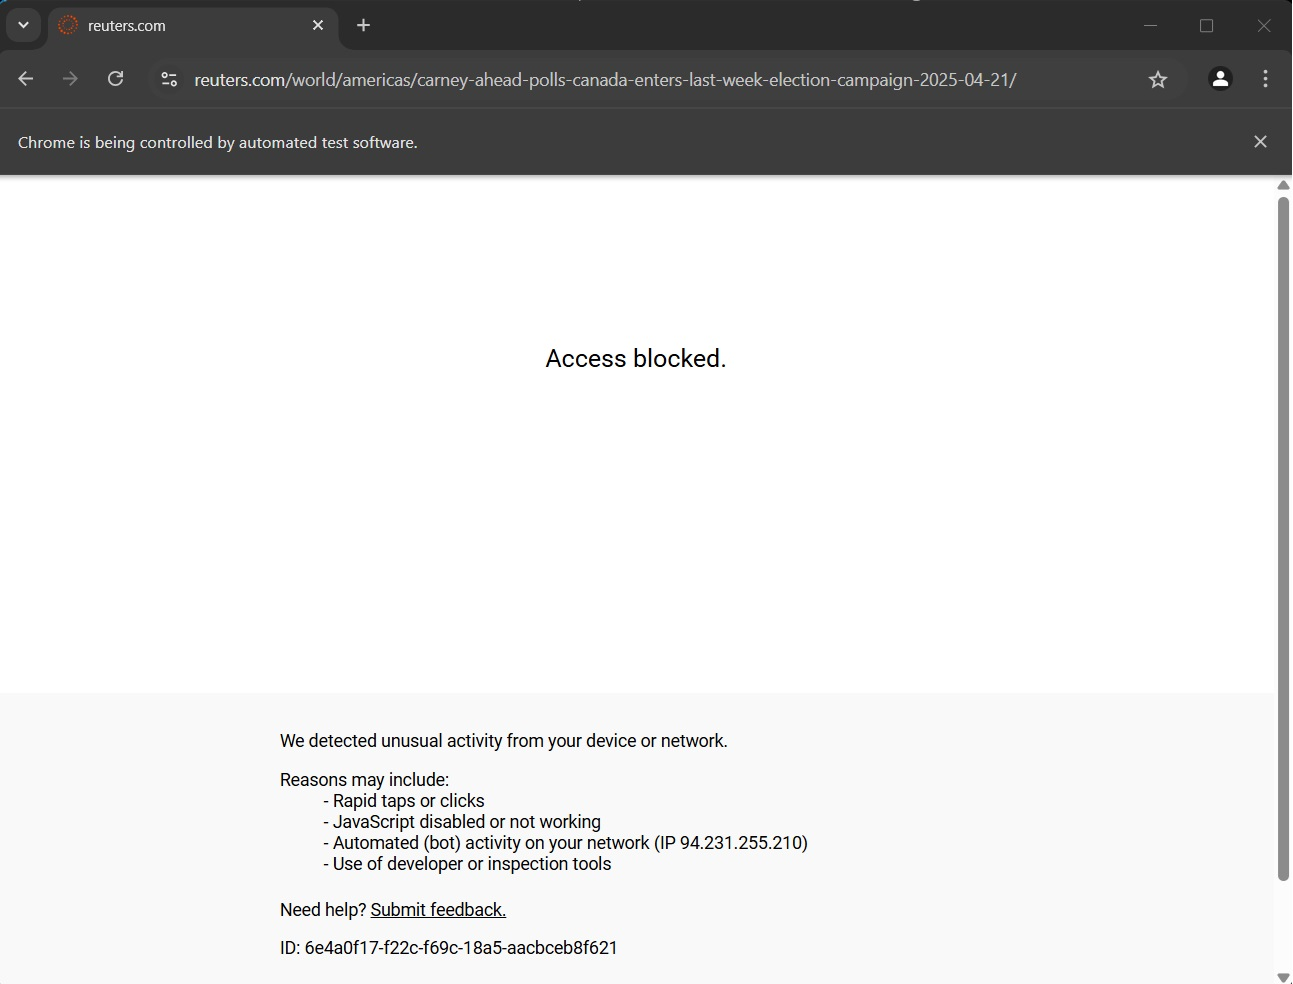

In [77]:
from IPython import display
display.Image('dataset/pics/routers.jpg')

### <a href="https://apnews.com/">AP News</a> ♦️ 
Provides unbiased, fact-based reporting.
As of now, I had to categorise each article by myself, so now I will scrape them by category for the first time.

In [90]:
BASE_URL = "https://apnews.com"

CATEGORY_URLS = {
    "World News": f"{BASE_URL}/world-news",
    "Politics": f"{BASE_URL}/politics",
    "Sports": f"{BASE_URL}/sports",
    "Entertainment": f"{BASE_URL}/entertainment",
    "Science": f"{BASE_URL}/science",
    "Economy": f"{BASE_URL}/business"
}

headers = {
    "User-Agent": "Mozilla/5.0"
}

all_articles = []

for category, url in CATEGORY_URLS.items():
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.content, "html.parser")

    articles_found = soup.find_all("h3", class_="PagePromo-title")
    article_urls = []

    for h3 in articles_found:
        a_tag = h3.find("a")
        if a_tag and a_tag.get("href"):
            href = a_tag["href"]
            full_url = href if href.startswith("http") else BASE_URL + href
            article_urls.append(full_url)

    article_urls = list(dict.fromkeys(article_urls))[:40]

    for idx, url in enumerate(article_urls):
        r = requests.get(url, headers=headers)
        article_soup = BeautifulSoup(r.content, "html.parser")

        # title
        title_tag = article_soup.find("h1")
        title = title_tag.get_text(strip=True) if title_tag else ""

        # author
        author = ""
        byline = article_soup.find("div", class_="Page-authors")
        if byline:
            author_tag = byline.find("a", class_="Link")
            if author_tag:
                author = author_tag.get_text(strip=True).title()

        # date
        date = ""
        date_container = article_soup.find("div", class_="Page-dateModified")
        if date_container:
            timestamp_tag = date_container.find("bsp-timestamp")
            if timestamp_tag and timestamp_tag.has_attr("data-timestamp"):
                timestamp_ms = int(timestamp_tag["data-timestamp"])
                dt = datetime.fromtimestamp(timestamp_ms / 1000)
                date = dt.strftime("%Y-%m-%d")

        # content
        content = ""
        body = article_soup.find("div", class_="RichTextStoryBody RichTextBody")
        if body:
            paragraphs = body.find_all("p")
            content = " ".join([p.get_text(strip=True) for p in paragraphs])

        all_articles.append({
            "Title": title,
            "URL": url,
            "Source": "AP News",
            "Journalist(s)": author,
            "Published Date": date,
            "Content": content,
            "Category": category,
            "Label": 1 # real news
        })

        time.sleep(1)

# save to csv
df = pandas.DataFrame(all_articles)
df.to_csv("apnews_real.csv", index=False)

print("Done.")


Done.


### <a href="https://www.nytimes.com/">The New York Times</a> 🗽 
Offers detailed reporting on a variety of topics, including politics and culture.